# Death prediction in disaster

### Stan Liu

#### 20/12/2018

- #### 1.Introduction
- #### 2.Data exploration and Feature Engineering
    - 2.1 Load data and packages
    - 2.2 Process null and missing values
    - 2.3 Check data Distribution
    - 2.4 Label encoding
    - 2.5 Feature expanding
    - 2.6 Split training and validation set
- #### 3.Model building and training
    - 3.1 Define the model
    - 3.2 Test base model
    - 3.3 Stack model
    - 3.4 Set loss function and optimizer
    - 3.5 Model Training
- #### 4.Emsembling
    - 4.1 Training and validation curves
    - 4.2 Accuracy
    - 4.3 Confusion matrix
- #### 5.Prediction and submition
    - 5.1 Predict single digit
    - 5.2 Submit results

## 1. Introduction

## 2. Data exploration and Feature Engineering

### 2.1 Load data and packages

In [204]:
# Load in our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import copy
import seaborn as sns
import random 
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
import xgboost as xgb

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
ntrain = len(train)
ntest = len(test)

In [6]:
# Obtain our labels
train_label = train['Survived']
# Drop the useless columns and concatenate the tables
train.drop(columns = ['PassengerId'], axis = 1, inplace = True)
test.drop(columns = ['PassengerId'], axis = 1, inplace = True)
all_data = pd.concat([train, test], axis = 0, ignore_index = True)

In [7]:
all_data.drop(columns = ['Survived'], inplace = True)

### 2.2 Process null and missing values

In [8]:
all_data.dtypes

Age         float64
Cabin        object
Embarked     object
Fare        float64
Name         object
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
Ticket       object
dtype: object

In [9]:
all_data.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Ticket         0
dtype: int64

 - Fill in all the nan values

In [10]:
all_data.Embarked.fillna(value = all_data.Embarked.mode().values[0], inplace = True)

In [11]:
all_data.Fare.fillna(value = all_data.Fare.mean(), inplace = True)

In [12]:
age_avg = all_data['Age'].mean()
age_std = all_data['Age'].std()

age_null_count = all_data['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
all_data['Age'][np.isnan(all_data['Age'])] = age_null_random_list

all_data['Age'] = all_data['Age'].astype(int)

In [13]:
all_data['Cabin'] = all_data['Cabin'].astype(str, copy = True)

In [16]:
all_data['Cabin'] = all_data['Cabin'].apply(lambda x: re.findall(r'([A-Z])\d*',x)[0] if x != 'nan' else 0)

In [54]:
all_data['Cabin'] = all_data['Cabin'].apply(lambda x: 'Z' if x == 0 else x)

### 2.3 Check Data Distribution

 - Then let's check some of the distributions

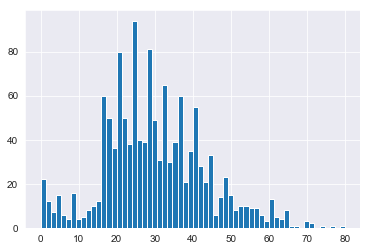

In [17]:
all_data.Age.hist(bins = 60)

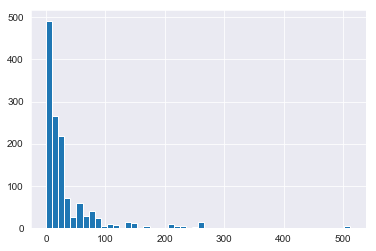

In [18]:
all_data.Fare.hist(bins = 50)

In [19]:
all_data.Fare.max()

512.3292

 -  Obviously, we find an outlier for tickert. we then consider to normalize it in oreder to obatin a better distribution

In [20]:
all_data['Fare'] = all_data['Fare'].apply(lambda x: 300 if x >= 500 else x)

 - Then we do binner for some continuous features

In [21]:
all_data['CategoricalAge'] = pd.cut(all_data['Age'], 5)

In [22]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
all_data['CategoricalFare'] = pd.qcut(all_data['Fare'], 5)

 - Also, we try to keep the contineous features. In that way, we need to adjust its distribution

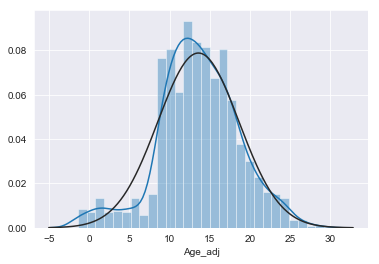

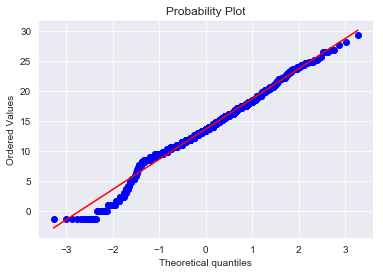

In [23]:
lambda_1 = 0.70
all_data['Age_adj'] = (np.power(all_data['Age'], lambda_1) - 1)/lambda_1

#Plot the histogram for the adjuested data
sns.distplot(all_data['Age_adj'] , fit=norm);

#Plot the qq plot
fig = plt.figure()
res = stats.probplot(np.array(all_data['Age_adj']), plot=plt)
plt.show()

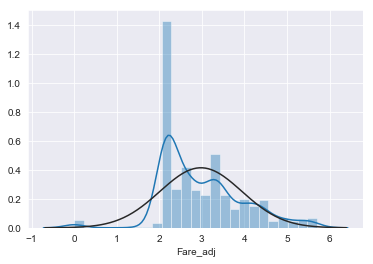

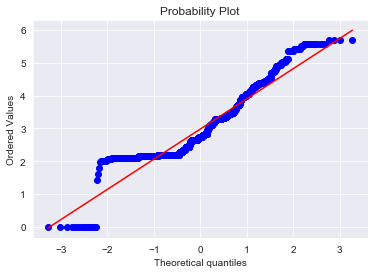

In [24]:
all_data['Fare_adj'] = np.log(all_data['Fare'] + 1)

#Plot the histogram for the adjuested data
sns.distplot(all_data['Fare_adj'] , fit=norm);

#Plot the qq plot
fig = plt.figure()
res = stats.probplot(np.array(all_data['Fare_adj']), plot=plt)
plt.show()

### 2.4 Label encoding

 - Here we extract a title variable

In [25]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
all_data['Title'] = all_data['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data['Title'] = all_data['Title'].replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')

In [28]:
def letter_match(string):
    result1 = re.search(r'^([A-Z]*\S*|[A-Z0-9].*/[A-Z0-9].*)\s',string)
    try:
        result1 = result1.group(0).strip()
        return result1
    except:
        return ''

In [29]:
def num_match(string):
    result2 = re.search(r'\w([0-9]+)$',string)
    try:
        result2 = result2.group(0).strip()
        return result2
    except:
        return ''

In [30]:
def num_len(string):
    if len(string) == 3:
        return 3
    elif len(string) == 4:
        return 4
    elif len(string) == 5:
        return 5
    elif len(string) == 6:
        return 6
    elif len(string) == 7:
        return 7
    else:
        return 0

In [32]:
Ticket= pd.DataFrame()
Ticket['Letter'] = all_data['Ticket'].apply(letter_match)
Ticket['Num'] = all_data['Ticket'].apply(num_match)

In [33]:
Ticket['num_len'] = Ticket['Num'].apply(num_len)

In [34]:
Ticket['num_len'].value_counts()

6    606
5    377
4    245
7     60
3     13
0      8
Name: num_len, dtype: int64

In [36]:
Ticket['Letter'].value_counts().head(10)

              961
PC             92
C.A.           46
SOTON/O.Q.     16
STON/O         14
W./C.          14
A/5            12
CA.            12
SC/PARIS       11
CA             10
Name: Letter, dtype: int64

 - In this way, we find perhaps the Letter of the ticket is just a way to show the start and the end or sth not quite useful. As a result, we just simply choose to drop this feature

In [38]:
Ticket.drop(columns = ['Letter'], axis = 1, inplace = True)

In [40]:
encoder = LabelEncoder()
# Mapping Sex
all_data['Sex'] = encoder.fit_transform(all_data['Sex']).astype(str)
    
# Mapping titles
all_data['Title'] = encoder.fit_transform(all_data['Title']).astype(str)
    
# Mapping Embarked
all_data['Embarked'] = encoder.fit_transform(all_data['Embarked']).astype(str)
    
# Mapping Fare
all_data['CategoricalFare'] = encoder.fit_transform(all_data['CategoricalFare']).astype(str)
    
# Mapping Age
all_data['CategoricalAge'] = encoder.fit_transform(all_data['CategoricalAge']).astype(str)

# Mapping Cabin
all_data['Cabin'] = encoder.fit_transform(all_data['Cabin']).astype(str)

#Concatenate DataFrame Ticket
data_complete = pd.concat([all_data, Ticket], axis=1, copy = True)

 - Drop the redundant features

In [60]:
data_complete.drop(columns = ['Age','Fare','Name','Ticket'], axis = 1, inplace = True)

In [69]:
data_complete['Num_1'] = data_complete['Num'].apply(lambda x: x[0] if len(x)>=1 else '0')
data_complete.drop(columns = ['Num'], axis = 1, inplace = True)

In [71]:
data_complete.head(5)

,Embarked,Parch,Pclass,Sex,SibSp,CategoricalAge,Age_adj,Fare_adj,Title,num_len,CategoricalFare,Cabin,Num_1
0,2,0,3,1,1,1,11.005056,2.110213,2,5,0,8,2
1,0,0,1,0,1,2,16.799909,4.280593,3,5,4,2,1
2,2,0,3,0,0,1,12.547442,2.188856,1,7,1,8,3
3,2,0,1,0,1,2,15.780189,3.990834,3,6,4,2,1
4,2,0,3,1,0,2,15.780189,2.202765,2,6,1,8,3


In [79]:
data_complete['Pclass'] = data_complete['Pclass'].astype(str)
data_complete['num_len'] = data_complete['num_len'].astype(str)

### 2.5 Feature expanding

In [83]:
data = pd.get_dummies(data_complete)

In [85]:
data.head(5)

,Parch,SibSp,Age_adj,Fare_adj,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3,...,Num_1_0,Num_1_1,Num_1_2,Num_1_3,Num_1_4,Num_1_5,Num_1_6,Num_1_7,Num_1_8,Num_1_9
0,0,1,11.005056,2.110213,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,1,16.799909,4.280593,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,12.547442,2.188856,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,1,15.780189,3.990834,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,15.780189,2.202765,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


### 2.6 Split training and validation set

In [161]:
X_train_complete = data_complete.loc[:ntrain-1].values
X_test_complete = data_complete.loc[ntrain:].values

In [96]:
X_train = data.loc[:ntrain-1].values
y_train = train_label.values
X_test = data.loc[ntrain:].values

## 3.Model building and training

### 3.1 Define the model

Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.

Creating a Stacking ensemble!

 - Helpers via Python Classes

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [139]:
# Some useful parameters which will come in handy later on
r = random.seed(2)
#SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
#kf = KFold(n_splits= NFOLDS, random_state=SEED)
#scores = cross_val_score()
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [176]:
def k_fold_spliter(train_len, i_fold, n_splits=5 ):
    train_list = range(train_len)
    left = train_len % n_splits
    
    if left != 0:
        batch = int(np.floor(train_len / n_splits))
        batch_1 = int(np.floor(train_len / n_splits)) + 1
        if i_fold  <= left-1:
            val_set = train_list[batch_1 * (i_fold-1): i_fold * batch_1]
            train_set = list(set(train_list).difference(set(val_set)))
        elif i_fold == left:
            val_set = train_list[batch_1 * (i_fold-1): i_fold * batch]
            train_set = list(set(train_list).difference(set(val_set)))
        else:
            val_set = train_list[batch * (i_fold-1): i_fold * batch]
            train_set = list(set(train_list).difference(set(val_set)))
    else:
        batch = int(train_len/n_splits)
        val_set = train_list[(i_fold-1)*batch : i_fold * batch]
        train_set = list(set(train_list).difference(set(val_set)))
    
    return train_set, val_set

 - Out-of-Fold Predictions
 - Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [196]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i in range(1,NFOLDS+1):
        train_index, test_index = k_fold_spliter(len(x_train), i, n_splits=NFOLDS)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i-1, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### 3.2 Generating our Base First-Level Models

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine
6. Logistic Regression
7. GaussianNB
8. BernoulliNB

In [218]:
# Put in our parameters for said classifiers

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 10,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.5,
    'gamma': 0.3
    }

# Logistic Regression Classifier parameters
lr_params = {
    'penalty':'l2',
    'C': 0.5,
    'solver':'newton-cg',
    'max_iter':1000,
    'n_jobs' : -1
}

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [217]:
#Perhaps we can solily adjust the parameter for SVC and other few classifiers.

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  kernel : string, optional (default='rbf')
 |      Specifies the kernel type to be used in the algorithm.
 |      It must be one of 'linear', 'poly',

In [219]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params = lr_params)

### 3.3 Output the first level predictions

In [220]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) # Random Forest

ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_test) # Gradient Boost

svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train, X_test) # Support Vector Classifier
lr_oof_train, lr_oof_test = get_oof(lr, X_train, y_train, X_test) # Logistic Regression Classifier

print("Training is complete")

Training is complete


In [221]:
ap_et = average_precision_score(y_train, et_oof_train)
ap_rf = average_precision_score(y_train, rf_oof_train)

ap_ada = average_precision_score(y_train, ada_oof_train)
ap_gb = average_precision_score(y_train, gb_oof_train)

ap_svc = average_precision_score(y_train, svc_oof_train)
ap_lr = average_precision_score(y_train, lr_oof_train)
print(ap_et,ap_rf,ap_ada,ap_gb,ap_svc, ap_lr)

0.7083823792316879 0.8151735110414704 0.6699329587181484 0.6536416799574694 0.6508801464941816 0.6878086465052347


In [222]:
x_train_2 = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, lr_oof_train), axis=1)
x_test_2 = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, lr_oof_test), axis=1)

In [223]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

scores = cross_val_score(gbm, x_train_2, y_train, cv=5)
print(scores)

[0.84916201 0.87150838 0.92696629 0.92134831 0.92655367]


In [228]:
gbm.fit(x_train_2, y_train)
predictions = gbm.predict(x_test_2)

In [234]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)